In [22]:
import pandas as pd
from math import *
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
import warnings
import os
from datetime import datetime
from src.PowerNNRegressor import PowerNNRegressor
from scipy import stats
import torch


warnings.filterwarnings("ignore")

### Parameters

In [23]:
metrics_filename="metrics.csv"
models={}
metrics_model={}

## Grid search with Cross validation

### Loading Data

In [24]:
train_data=pd.read_csv("data/train_prep.csv")
test_data=pd.read_csv("data/test_prep.csv")
#Check if metrics file exists
if os.path.isfile('./'+metrics_filename):
    metrics=pd.read_csv(metrics_filename)
else:
    metrics=pd.DataFrame(columns=["date","model","params","best_train_score","RMSE","MSE","MAE"])

### Training Data


Crossvalidation fold: 1/3

	Epoch: 1/5
		Iter	Loss			Rel. loss
		100	0.07100849	0.0016704473
		200	0.06262221	0.0010464931
		300	0.056638986	0.0009518742
		400	0.05130922	0.0010427493
		500	0.046032883	0.0011081143
		600	0.04153353	0.000924692
		700	0.038157217	0.0007751669
		800	0.035539877	0.00065050885
		900	0.033573776	0.00048454208
		1000	0.03223223	0.00034822646
		Final loss:
		1000	0.03223223	0.00034822646

	Epoch: 2/5
		Iter	Loss			Rel. loss
		100	0.06643078	0.0018167538
		200	0.055792294	0.0015127353
		300	0.048640255	0.0013290353
		400	0.042117205	0.001386748
		500	0.03817978	0.0008428019
		600	0.035354383	0.0007083217
		700	0.033088204	0.00062221684
		800	0.031179678	0.00057614996
		900	0.029373234	0.0006458879
		1000	0.027158093	0.0009577667
		Final loss:
		1000	0.027158093	0.0009577667

	Epoch: 3/5
		Iter	Loss			Rel. loss
		100	0.05714675	0.0017511409
		200	0.048880566	0.0016272956
		300	0.04172371	0.0015482963
		400	0.035882004	0.0014380243
		500	0.031252205	0.0013509832

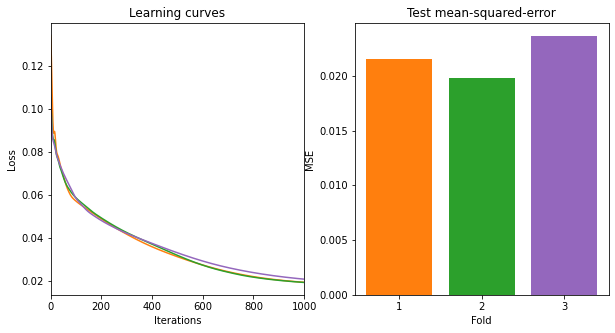

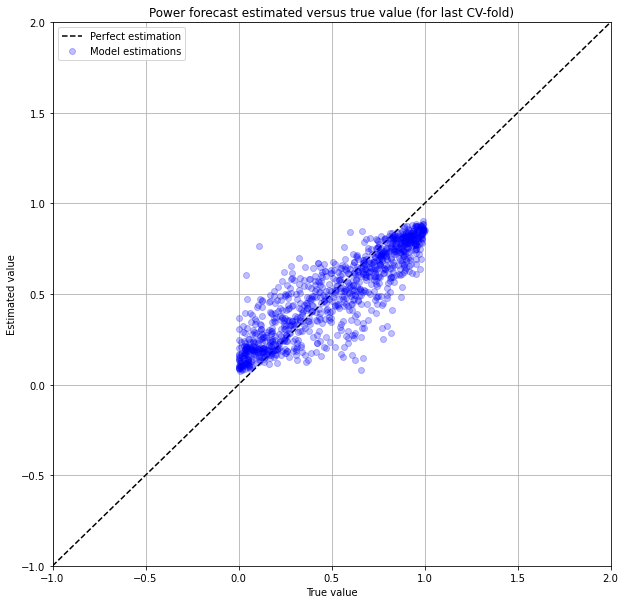

In [25]:
X = train_data[['U10','U100','V10','V100','POWER']]
          
X=np.array(X)
attributeNames=['U10','U100','V10','V100']

y=X[:,[4]] 
X=X[:,0:4]
N, M = X.shape
#C = 2


                
## Normalize and compute PCA (change to True to experiment with PCA preprocessing)
do_pca_preprocessing = False
if do_pca_preprocessing:
    Y = stats.zscore(X,0);
    U,S,V = np.linalg.svd(Y,full_matrices=False)
    V = V.T
    #Components to be included as features
    k_pca = 3
    X = X @ V[:,0:k_pca]
    N, M = X.shape


# Parameters for neural network classifier
n_hidden_units = 15      # number of hidden units
n_epochs = 5        # number of networks trained in each k-fold
max_iter = 1000        # 

# K-fold crossvalidation
K = 3                   
CV = KFold(K, shuffle=True)


summaries, summaries_axes = plt.subplots(1,2, figsize=(10,5))

color_list = ['tab:orange', 'tab:green', 'tab:purple', 'tab:brown', 'tab:pink',
              'tab:gray', 'tab:olive', 'tab:cyan', 'tab:red', 'tab:blue']
# Define the model
model = torch.nn.Sequential(
        torch.nn.Linear(M, n_hidden_units), #M features to n_hidden_units
        torch.nn.Tanh(),   # 1st transfer function,
        torch.nn.Linear(n_hidden_units, 1),# n_hidden_units to 1 output neuron
        torch.nn.Sigmoid() #2nd tranfer function
        
        )


#Instanciate the model
nn_model=PowerNNRegressor(model,"regression",n_epochs,max_iter)

errors = [] # make a list for storing generalizaition error in each loop
for (k, (train_index, test_index)) in enumerate(CV.split(X,y)): 
    print('\nCrossvalidation fold: {0}/{1}'.format(k+1,K))    
    
    # Extract training and test set for current CV fold, convert to tensors
    X_train = torch.tensor(X[train_index,:], dtype=torch.float)
    y_train = torch.tensor(y[train_index], dtype=torch.float)
    X_test = torch.tensor(X[test_index,:], dtype=torch.float)
    y_test = torch.tensor(y[test_index], dtype=torch.float)
    
    # Train the net on training data
    best_net, best_final_loss, best_learning_curve = nn_model.train(X_train,y_train)
    
    print('\n\tBest loss: {}\n'.format(best_final_loss))
    
    # Determine estimated class labels for test set
    nn_model.load_state_dict(best_net)
    y_test_est = nn_model(X_test)
    
    # Determine errors and errors
    se = (y_test_est.float()-y_test.float())**2 # squared error
    mse = (sum(se).type(torch.float)/len(y_test)).data.numpy() #mean
    errors.append(mse) # store error rate for current CV fold 
    
    # Display the learning curve for the best net in the current fold
    h, = summaries_axes[0].plot(best_learning_curve, color=color_list[k])
    h.set_label('CV fold {0}'.format(k+1))
    summaries_axes[0].set_xlabel('Iterations')
    summaries_axes[0].set_xlim((0, max_iter))
    summaries_axes[0].set_ylabel('Loss')
    summaries_axes[0].set_title('Learning curves')

# Display the MSE across folds
summaries_axes[1].bar(np.arange(1, K+1), np.squeeze(np.asarray(errors)), color=color_list)
summaries_axes[1].set_xlabel('Fold');
summaries_axes[1].set_xticks(np.arange(1, K+1))
summaries_axes[1].set_ylabel('MSE');
summaries_axes[1].set_title('Test mean-squared-error')   


# Print the average classification error rate
print('\nEstimated generalization error, RMSE: {0}'.format(round(np.sqrt(np.mean(errors)), 4)))


plt.figure(figsize=(10,10));
y_est = y_test_est.data.numpy(); y_true = y_test.data.numpy();
axis_range = [np.min([y_est, y_true])-1,np.max([y_est, y_true])+1]
plt.plot(axis_range,axis_range,'k--')
plt.plot(y_true[0:1000], y_est[0:1000],'ob',alpha=.25)
plt.legend(['Perfect estimation','Model estimations'])
plt.title('Power forecast estimated versus true value (for last CV-fold)')
plt.ylim(axis_range); plt.xlim(axis_range)
plt.xlabel('True value')
plt.ylabel('Estimated value')
plt.grid()
plt.show()

Learning curves are quite smooth, since we are using a batch gradient descent (the model is trained on all samples in each iteration). They are just beginning to reach a plateau
